<a href="https://colab.research.google.com/github/swicklund/hackathon/blob/main/RevisedPhysicsModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import seaborn as sns
import tensorflow as tf
import json
import zipfile
from io import BytesIO
import torch
import math
from google.colab import files
from google.colab import auth
from datetime import datetime, timedelta


In [4]:
auth.authenticate_user()

In [5]:
!gcloud config set project {'hackathon-352519'}

Updated property [core/project].


In [6]:
!gsutil cp gs://trains_data/* /tmp/.

Copying gs://trains_data/train-data_all-train-events.zip...
- [1 files][ 57.1 MiB/ 57.1 MiB]                                                
Operation completed over 1 objects/57.1 MiB.                                     


In [28]:
# z = zipfile.ZipFile('train-data_all-train-events.zip', 'r')

x = {}
trains = {}
i = 1
prevLoco = ''
with zipfile.ZipFile("/tmp/train-data_all-train-events.zip", "r") as f:
    for name in f.namelist():
        if name.endswith('.json'):
            with f.open(name) as zd:
                data = json.load(zd)
                lastTrainReporting = data['lastTrainReporting']
                currentLoco = lastTrainReporting['ptcLeadLocomotiveId']
                # prevLoco != currentLoco and 
                if ("trainActualPositionList" in lastTrainReporting and "trainEstimatedPositionList" in lastTrainReporting and len(lastTrainReporting['trainEstimatedPositionList']) > 0): 
                    trainActualPositionList = lastTrainReporting['trainActualPositionList']
                    for position in trainActualPositionList:
                        positions = pd.json_normalize(position)
                        trains[i] = pd.json_normalize(lastTrainReporting)
#                             x[i] = pd.concat([train.ptcLeadLocomotiveId,trains[i]["trainId.trainSymbol"], trains[i]["trainId.trainDate"], positions], axis=1)
                        x[i] = positions
#                             trains[i] = train 
                        i = i + 1
                        prevLoco = currentLoco
                            

In [29]:
df = pd.concat(x.values())
dfTrainsAll = pd.concat(trains.values())

In [34]:
del x
del trains

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143050 entries, 0 to 0
Data columns (total 13 columns):
 #   Column                                                Non-Null Count   Dtype  
---  ------                                                --------------   -----  
 0   positionTime                                          143050 non-null  object 
 1   speedMPH                                              143050 non-null  int64  
 2   milepostLocation.subdivisionId                        143050 non-null  int64  
 3   milepostLocation.trackName                            143050 non-null  object 
 4   milepostLocation.milepost.milepostNumber              143050 non-null  float64
 5   nextSignalState.milepostLocation.milepostNumber       123498 non-null  float64
 6   nextSignalState.signalState                           123498 non-null  float64
 7   precedingSignalState.milepostLocation.milepostNumber  124689 non-null  float64
 8   precedingSignalState.previousSignalState         

In [33]:
print(dfTrainsAll.info())
print(dfTrainsAll.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143050 entries, 0 to 0
Data columns (total 44 columns):
 #   Column                                                                     Non-Null Count   Dtype  
---  ------                                                                     --------------   -----  
 0   ptcLeadLocomotiveId                                                        143050 non-null  object 
 1   maximumTrainSpeed                                                          143050 non-null  int64  
 2   loadedCarCount                                                             143050 non-null  int64  
 3   emptyCarCount                                                              143050 non-null  int64  
 4   trainLength                                                                143050 non-null  int64  
 5   trailingTonnage                                                            143050 non-null  int64  
 6   positionHistoryList                              

# Step 2: Augment Existing Physics BEoP model with standard deviations from most recent readings.

In [71]:
dfTrainsAll["milepost"] = dfTrainsAll.apply(lambda row: math.trunc(row['lastReportedPosition.milepostLocation.milepost.milepostNumber']), axis=1)
dfTrainsAll["hour"] = dfTrainsAll.apply(lambda row: (row['lastReportedPosition.positionTime']).rsplit(":")[0], axis=1)

In [72]:
dfTrainsAll.head()

,ptcLeadLocomotiveId,maximumTrainSpeed,loadedCarCount,emptyCarCount,trainLength,trailingTonnage,positionHistoryList,locomotiveList,subdivisionList,trainEstimatedPositionList,...,lastReportedPosition.nextSignalState.milepostLocation.milepostNumber,lastReportedPosition.nextSignalState.signalState,lastReportedPosition.precedingSignalState.milepostLocation.milepostNumber,lastReportedPosition.precedingSignalState.previousSignalState,lastReportedPosition.precedingSignalState.currentStateTime,lastReportedPosition.precedingSignalState.signalState,lastReportedPosition.nextSignalState.previousSignalState,lastReportedPosition.nextSignalState.currentStateTime,milepost,hour
0,UP2010,50,61,92,9282,10992,"[{'positionTime': '2022-04-21T23:31:08Z', 'spe...","[{'locomotiveId': 'UP2010', 'positionOnTrain':...","[{'subdivisionId': 595}, {'subdivisionId': 538...","[{'positionTime': '2022-04-21T23:31:08Z', 'spe...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,766,2022-04-21T23
0,UP2010,50,61,92,9282,10992,"[{'positionTime': '2022-04-21T23:31:08Z', 'spe...","[{'locomotiveId': 'UP2010', 'positionOnTrain':...","[{'subdivisionId': 595}, {'subdivisionId': 538...","[{'positionTime': '2022-04-21T23:31:08Z', 'spe...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,766,2022-04-21T23
0,UP2010,50,61,92,9282,10992,"[{'positionTime': '2022-04-21T23:31:08Z', 'spe...","[{'locomotiveId': 'UP2010', 'positionOnTrain':...","[{'subdivisionId': 595}, {'subdivisionId': 538...","[{'positionTime': '2022-04-21T23:31:08Z', 'spe...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,766,2022-04-21T23
0,UP2010,50,61,92,9282,10992,"[{'positionTime': '2022-04-21T23:31:08Z', 'spe...","[{'locomotiveId': 'UP2010', 'positionOnTrain':...","[{'subdivisionId': 595}, {'subdivisionId': 538...","[{'positionTime': '2022-04-21T23:31:08Z', 'spe...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,766,2022-04-21T23
0,UP2010,50,61,92,9282,10992,"[{'positionTime': '2022-04-21T23:31:08Z', 'spe...","[{'locomotiveId': 'UP2010', 'positionOnTrain':...","[{'subdivisionId': 595}, {'subdivisionId': 538...","[{'positionTime': '2022-04-21T23:31:08Z', 'spe...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,766,2022-04-21T23


In [96]:
dfTrains = dfTrainsAll.drop_duplicates(subset=['ptcLeadLocomotiveId', 'trainId.trainSymbol', 'trainId.trainDate', 'hour'], keep='first')
print(dfTrains.shape)
print(dfTrains.iloc[0])

(186, 46)
ptcLeadLocomotiveId                                                                                                     UP2010
maximumTrainSpeed                                                                                                           50
loadedCarCount                                                                                                              61
emptyCarCount                                                                                                               92
trainLength                                                                                                               9282
trailingTonnage                                                                                                          10992
positionHistoryList                                                          [{'positionTime': '2022-04-21T23:31:08Z', 'spe...
locomotiveList                                                               [{'locomotiveId': 'UP201

In [110]:
print(dfTrains.iloc[25]['trainId.trainSymbol'], dfTrains.iloc[25]['trainActualPositionList'])
act = pd.json_normalize(dfTrains.iloc[25]['trainActualPositionList'])
print(act['positionTime'])

MALNP [{'positionTime': '2022-04-22T05:40:20Z', 'speedMPH': 7, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 2-MT 1', 'milepost': {'milepostNumber': 202.98804}}, 'precedingSignalState': {'milepostLocation': {'milepostNumber': 202.73}, 'signalState': 1}, 'nextSignalState': {'milepostLocation': {'milepostNumber': 204.19}, 'signalState': 4}}, {'positionTime': '2022-04-22T05:42:20Z', 'speedMPH': 7, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 203.2537}}, 'precedingSignalState': {'milepostLocation': {'milepostNumber': 202.73}, 'signalState': 1}, 'nextSignalState': {'milepostLocation': {'milepostNumber': 204.19}, 'signalState': 4}}, {'positionTime': '2022-04-22T05:44:20Z', 'speedMPH': 10, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 203.58463}}, 'precedingSignalState': {'milepostLocation': {'milepostNumber': 202.73}, 'signalState': 1}, 'nextSignalState': {'milepostLocation': {'mi

In [154]:
def formatTrain(dfTrain):
  actuals = pd.json_normalize(dfTrain['trainActualPositionList'])
  cols = list(actuals.columns)
  dfx = (actuals[cols[0:2] + cols[3:5]])
  dfx = dfx.rename(columns={"speedMPH" : "speedMPH", "milepostLocation.trackName":"trackName", "milepostLocation.milepost.milepostNumber": "milepostNumber" })
  est = pd.json_normalize(dfTrain['trainEstimatedPositionList'])  
  beop = est.rename(columns={"speedMPH" : "forecastSpeedMPH", "milepostLocation.trackName":"forecastTrackName", "milepostLocation.milepost.milepostNumber": "forecastMilepostNumber" })
  joined = beop.join(dfx, lsuffix='_beop', rsuffix='_actual')
  dn = joined.dropna()
  dn = dn.loc[(dn['speedMPH'] != 0)]
  delta = abs(dn["speedMPH"] - dn["forecastSpeedMPH"]);
  #dn = dn.apply(lambda x: abs(x) if x.name=='speedMPH' or  x.name=='forecastSpeedMPH' else x)
  dn["delta"] = delta
  try:
    dn['milepost'] = dn.apply(lambda row: math.trunc(row['milepostNumber']), axis=1) 
    dn['millis'] = dn.apply(lambda row: ((datetime.strptime(row['positionTime_actual'], "%Y-%m-%dT%H:%M:%SZ"))  - datetime(1970, 1, 1)) // timedelta(milliseconds=1), axis=1)
  except ValueError:
    print (ValueError)
    print("Oops!  invalid format", dn)
  dn['trainId'] = dfTrain['trainId.trainSymbol']+" "+dfTrain['trainId.trainDate']
  dn = dn.drop(columns=['milepostLocation.subdivisionId'])
  # dn = dn.reset_index()
  return dn

In [189]:
trainsList = []
for index, train in dfTrains.iterrows():
  # print(train['trainId.trainSymbol'])
  trainsList.append(formatTrain(train))
trains = pd.concat(trainsList)
trains.sort_values(['trainId','milepost', 'positionTime_actual'])
trains = trains.drop_duplicates(subset=['trainId', 'milepost'], keep='last')
trains = trains.reset_index()

<class 'ValueError'>
Oops!  invalid format Empty DataFrame
Columns: [positionTime_beop, forecastSpeedMPH, milepostLocation.subdivisionId, forecastTrackName, forecastMilepostNumber, positionTime_actual, speedMPH, trackName, milepostNumber, delta]
Index: []


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [190]:
trains.loc[trains['trainId'].str.startswith('MALNP')]

,index,positionTime_beop,forecastSpeedMPH,forecastTrackName,forecastMilepostNumber,positionTime_actual,speedMPH,trackName,milepostNumber,delta,milepost,millis,hour,trainId
436,15,2022-04-22T06:08:20Z,50,YD LD,224.92500,2022-04-22T06:12:20Z,1.0,MT 2,202.92322,49.0,202.0,1.650608e+12,2022-04-22T06,MALNP 2022-04-18
437,21,2022-04-22T06:20:20Z,50,YD LD,234.92460,2022-04-22T06:24:20Z,39.0,MT 1,206.42480,11.0,206.0,1.650609e+12,2022-04-22T06,MALNP 2022-04-18
438,27,2022-04-22T06:32:20Z,50,YD LD,244.92420,2022-04-22T06:36:20Z,12.0,MT 1,212.20686,38.0,212.0,1.650609e+12,2022-04-22T06,MALNP 2022-04-18
439,34,2022-04-22T06:46:20Z,50,YD LD,256.59040,2022-04-22T06:52:20Z,47.0,MT 1,221.68124,3.0,221.0,1.650610e+12,2022-04-22T06,MALNP 2022-04-18
440,36,2022-04-22T06:50:20Z,50,YD LD,259.92360,2022-04-22T06:56:20Z,41.0,MT 1,224.64595,9.0,224.0,1.650611e+12,2022-04-22T06,MALNP 2022-04-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1734,30,2022-04-25T19:00:00Z,50,MT 2,323.94800,2022-04-25T19:02:00Z,36.0,MT 2,321.06220,14.0,321.0,1.650913e+12,2022-04-25T19,MALNP 2022-04-22
1735,0,2022-04-25T19:01:38Z,36,MT 2,320.84540,2022-04-25T19:03:38Z,36.0,MT 2,322.02790,0.0,322.0,1.650913e+12,2022-04-25T19,MALNP 2022-04-22
1736,1,2022-04-25T19:03:38Z,40,MT 2,322.10930,2022-04-25T19:05:38Z,35.0,MT 2,323.21686,5.0,323.0,1.650914e+12,2022-04-25T19,MALNP 2022-04-22
1737,2,2022-04-25T19:05:38Z,44,MT 2,323.51822,2022-04-25T19:07:38Z,36.0,MT 2,324.41382,8.0,324.0,1.650914e+12,2022-04-25T19,MALNP 2022-04-22


Compute the Change of Velocity entering each milepost segment

In [191]:

trains['speedChange'] = trains["speedMPH"]
prevTrain = ''
for i in range(0, len(trains)):
  if trains.loc[i, "trainId"] == prevTrain :
    trains.loc[i, "speedChange"] = trains.loc[i, "speedMPH"] - trains.loc[i-1, "speedMPH"]
  else :  
    trains.loc[i, "speedChange"] = 0.0
  prevTrain = trains.loc[i, "trainId"]
trains

,index,positionTime_beop,forecastSpeedMPH,forecastTrackName,forecastMilepostNumber,positionTime_actual,speedMPH,trackName,milepostNumber,delta,milepost,millis,hour,trainId,speedChange
0,1,2022-04-21T23:33:08Z,-19,WEST MAIN,766.40760,2022-04-21T23:35:08Z,-10.0,WEST MAIN-MAIN,766.19630,9.0,766.0,1.650584e+12,2022-04-21T23,MEWLI 2022-04-21,0.0
1,4,2022-04-21T23:39:08Z,-34,WEST MAIN,763.60770,2022-04-21T23:41:08Z,-8.0,MAIN,765.24010,26.0,765.0,1.650584e+12,2022-04-21T23,MEWLI 2022-04-21,2.0
2,0,2022-04-21T21:55:32Z,-35,MT 2,326.18050,2022-04-21T21:57:32Z,-35.0,MT 2,325.00015,0.0,325.0,1.650578e+12,2022-04-21T21,ILBG3 2022-04-16,0.0
3,1,2022-04-21T21:57:32Z,-39,MT 2,324.97513,2022-04-21T21:59:32Z,-35.0,MT 2,323.82498,4.0,323.0,1.650578e+12,2022-04-21T21,ILBG3 2022-04-16,0.0
4,2,2022-04-21T21:59:32Z,-43,MT 2,323.59308,2022-04-21T22:01:32Z,-33.0,MT 2,322.71332,10.0,322.0,1.650578e+12,2022-04-21T22,ILBG3 2022-04-16,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3183,46,2022-04-22T12:32:53Z,50,MAIN,802.88890,2022-04-22T12:34:53Z,2.0,MAIN,762.86145,48.0,762.0,1.650631e+12,2022-04-22T12,UEUMTG 2022-04-11,-37.0
3184,4,2022-04-22T12:42:41Z,36,MAIN,766.03930,2022-04-22T12:44:41Z,4.0,MAIN,763.86804,32.0,763.0,1.650631e+12,2022-04-22T12,UEUMTG 2022-04-11,2.0
3185,6,2022-04-22T12:46:41Z,44,MAIN,768.73460,2022-04-22T12:48:41Z,17.0,MAIN,764.67334,27.0,764.0,1.650632e+12,2022-04-22T12,UEUMTG 2022-04-11,13.0
3186,8,2022-04-22T12:50:41Z,50,MAIN,771.88110,2022-04-22T12:52:41Z,18.0,MAIN-TO_N_EAST MAIN,765.97064,32.0,765.0,1.650632e+12,2022-04-22T12,UEUMTG 2022-04-11,1.0


In [192]:
mps = trains['milepost'].unique()
mps.sort()
mps

array([202., 203., 204., 205., 206., 207., 208., 209., 210., 211., 212.,
       213., 214., 215., 216., 217., 218., 219., 220., 221., 222., 223.,
       224., 225., 226., 227., 228., 229., 230., 231., 232., 233., 234.,
       235., 236., 237., 238., 239., 240., 241., 242., 243., 244., 245.,
       246., 247., 248., 249., 250., 251., 252., 253., 254., 255., 256.,
       257., 258., 259., 260., 261., 262., 263., 264., 265., 266., 267.,
       268., 269., 270., 271., 272., 273., 274., 275., 276., 277., 278.,
       279., 280., 281., 282., 283., 284., 285., 286., 287., 288., 289.,
       290., 291., 292., 293., 294., 295., 296., 297., 298., 299., 300.,
       301., 302., 303., 304., 305., 306., 307., 308., 309., 310., 311.,
       312., 313., 314., 315., 316., 317., 318., 319., 320., 321., 322.,
       323., 324., 325., 326., 720., 721., 722., 723., 724., 725., 726.,
       727., 728., 729., 730., 731., 732., 733., 734., 735., 736., 737.,
       738., 739., 740., 741., 742., 743., 744., 74

In [207]:
print(trains.iloc[0])

index                                        1
positionTime_beop         2022-04-21T23:33:08Z
forecastSpeedMPH                           -19
forecastTrackName                    WEST MAIN
forecastMilepostNumber                766.4076
positionTime_actual       2022-04-21T23:35:08Z
speedMPH                                 -10.0
trackName                       WEST MAIN-MAIN
milepostNumber                        766.1963
delta                                      9.0
milepost                                 766.0
millis                         1650584108000.0
hour                             2022-04-21T23
trainId                       MEWLI 2022-04-21
speedChange                                0.0
Name: 0, dtype: object


In [212]:

with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.width', 1000,
                       'display.precision', 3,
                       ):
  vals = trains.loc[trains['trainId'] == 'ITAG3 2022-04-20']
  print(vals[['positionTime_actual', 'milepost', 'milepostNumber','forecastSpeedMPH', 'speedMPH']])

      positionTime_actual  milepost  milepostNumber  forecastSpeedMPH  speedMPH
116  2022-04-24T12:40:29Z     324.0         324.968               -33     -36.0
117  2022-04-24T12:44:29Z     322.0         322.452               -37     -37.0
118  2022-04-24T12:46:29Z     321.0         321.213               -41     -37.0
119  2022-04-24T12:48:29Z     319.0         319.993               -45     -36.0
120  2022-04-24T12:50:29Z     318.0         318.716               -48     -38.0
121  2022-04-24T12:52:29Z     317.0         317.363               -51     -40.0
122  2022-04-24T12:54:29Z     315.0         315.959               -54     -42.0
123  2022-04-24T12:56:29Z     314.0         314.519               -56     -43.0
124  2022-04-24T12:58:29Z     313.0         313.021               -58     -45.0
125  2022-04-24T13:00:29Z     311.0         311.457               -61     -47.0
126  2022-04-24T13:02:29Z     309.0         309.864               -63     -47.0
127  2022-04-24T13:06:29Z     306.0     

In [179]:
dfTrains.iloc[3]["trainEstimatedPositionList"]                                                   

[{'milepostLocation': {'milepost': {'milepostNumber': 284.1967},
   'subdivisionId': 106,
   'trackName': 'MT 2'},
  'positionTime': '2022-04-21T23:01:13Z',
  'speedMPH': -39},
 {'milepostLocation': {'milepost': {'milepostNumber': 282.85425},
   'subdivisionId': 106,
   'trackName': 'MT 2'},
  'positionTime': '2022-04-21T23:03:13Z',
  'speedMPH': -42},
 {'milepostLocation': {'milepost': {'milepostNumber': 281.3805},
   'subdivisionId': 106,
   'trackName': 'MT 2'},
  'positionTime': '2022-04-21T23:05:13Z',
  'speedMPH': -46},
 {'milepostLocation': {'milepost': {'milepostNumber': 279.78912},
   'subdivisionId': 106,
   'trackName': 'MT 2'},
  'positionTime': '2022-04-21T23:07:13Z',
  'speedMPH': -49},
 {'milepostLocation': {'milepost': {'milepostNumber': 278.0921},
   'subdivisionId': 106,
   'trackName': 'MT 2'},
  'positionTime': '2022-04-21T23:09:13Z',
  'speedMPH': -52},
 {'milepostLocation': {'milepost': {'milepostNumber': 276.28278},
   'subdivisionId': 106,
   'trackName': 'MT 2'

In [ ]:
dfTrains.iloc[3]

In [194]:
mpSpeedsPositive = {}
for mp in mps:
  mpTrains = trains.loc[trains['milepost'].between(mp - 1, mp +1)]
  mpSpeedsPositive[mp] = (mpTrains.loc[mpTrains.speedMPH > 0])[["speedChange"]].mean()
mpSpeedsPositive


{202.0: speedChange   -1.5
 dtype: float64, 203.0: speedChange    0.666667
 dtype: float64, 204.0: speedChange    5.636364
 dtype: float64, 205.0: speedChange    11.043478
 dtype: float64, 206.0: speedChange    10.636364
 dtype: float64, 207.0: speedChange    5.04
 dtype: float64, 208.0: speedChange   -1.111111
 dtype: float64, 209.0: speedChange   -3.633333
 dtype: float64, 210.0: speedChange   -5.04
 dtype: float64, 211.0: speedChange   -6.75
 dtype: float64, 212.0: speedChange   -2.4
 dtype: float64, 213.0: speedChange   -2.1875
 dtype: float64, 214.0: speedChange   -0.208333
 dtype: float64, 215.0: speedChange   -0.307692
 dtype: float64, 216.0: speedChange    0.533333
 dtype: float64, 217.0: speedChange    2.178571
 dtype: float64, 218.0: speedChange    4.285714
 dtype: float64, 219.0: speedChange    5.321429
 dtype: float64, 220.0: speedChange    5.689655
 dtype: float64, 221.0: speedChange    3.428571
 dtype: float64, 222.0: speedChange    2.266667
 dtype: float64, 223.0: speedC

In [195]:
mpSpeedsNegative = {}
for mp in mps:
  mpTrains = trains.loc[trains['milepost'].between(mp - 1, mp +1)]
  mpSpeedsNegative[mp] = (mpTrains.loc[mpTrains.speedMPH < 0])[["speedChange"]].mean()
mpSpeedsNegative


{202.0: speedChange    4.588235
 dtype: float64, 203.0: speedChange    4.419355
 dtype: float64, 204.0: speedChange    2.282051
 dtype: float64, 205.0: speedChange   -1.945946
 dtype: float64, 206.0: speedChange   -2.342857
 dtype: float64, 207.0: speedChange   -1.083333
 dtype: float64, 208.0: speedChange    1.0
 dtype: float64, 209.0: speedChange   -1.027778
 dtype: float64, 210.0: speedChange   -1.533333
 dtype: float64, 211.0: speedChange    0.913043
 dtype: float64, 212.0: speedChange    2.388889
 dtype: float64, 213.0: speedChange    2.434783
 dtype: float64, 214.0: speedChange    0.965517
 dtype: float64, 215.0: speedChange    2.361111
 dtype: float64, 216.0: speedChange    3.243243
 dtype: float64, 217.0: speedChange    4.194444
 dtype: float64, 218.0: speedChange    2.305556
 dtype: float64, 219.0: speedChange    2.727273
 dtype: float64, 220.0: speedChange    0.8
 dtype: float64, 221.0: speedChange    1.375
 dtype: float64, 222.0: speedChange    0.228571
 dtype: float64, 223.

In [201]:
def plotTrain(trainData, trainId):
  ax = plt.gca()
  trainDF = trainData.loc[trainData['trainId'] == trainId]
  trainDF = trainDF.reset_index();
  trainsDF = trainDF.sort_values('positionTime_actual')
  trainDF = trainDF.apply(lambda x: abs(x) if x.name=='speedMPH' or  x.name=='forecastSpeedMPH' else x)  
  trainDF.plot(x = 'milepostNumber', y="speedMPH", use_index=True, kind="scatter", ax=ax, figsize=[24,10])
  trainDF.plot(x = 'milepostNumber', y="forecastSpeedMPH", use_index=True, kind="scatter", color="red", ax=ax, figsize=[24,10])
  trainDF.plot(x = 'milepostNumber', y="delta", use_index=True, kind="line", color="green", ax=ax, figsize=[24,10])
  # plt.gcf().autofmt_xdate()
  (t,b)= ax.get_xlim()  ## Added for clarity
  if t < b:
    ax.set_xlim((b,t))
  plt.title(trainId)
  plt.show()

In [197]:
trainIdsList = trains['trainId'].unique()
print(trainIdsList.size)
print(trainIdsList)

47
['MEWLI 2022-04-21' 'ILBG3 2022-04-16' 'MSALI 2022-04-22'
 'ITAG3 2022-04-20' 'MCBDM 2022-04-20' 'MPRNP 2022-04-21'
 'MALNP 2022-04-18' 'MNPAL 2022-04-23' 'MSALI 2022-04-20'
 'ZLTG2 2022-04-21' 'CBVNR9 2022-04-21' 'IG4SE 2022-04-21'
 'ITAG3 2022-04-16' 'MCHCB 2022-04-22' 'ZSCG2 2022-04-22'
 'MNPCH 2022-04-21' 'MNPSSB 2022-04-19' 'MLKBT 2022-04-23'
 'MHOLI 2022-04-20' 'MHOLI 2022-04-23' 'MLIHO 2022-04-21'
 'MLIHO 2022-04-23' 'MALNP 2022-04-22' 'MCHNP 2022-05-04'
 'MBTLK 2022-05-02' 'MLIBT 2022-05-01' 'CPWNR9 2022-04-21'
 'MCBDM 2022-04-21' 'CBTWK9 2022-04-22' 'CWTOK 2022-04-30'
 'MCHCB 2022-05-01' 'ZBRG2B 2022-04-22' 'ZG2SC 2022-05-03'
 'ZLTG2 2022-05-01' 'MPRNP 2022-04-25' 'MLIBT 2022-05-04'
 'WNLDYB 2022-04-15' 'MLIBT 2022-04-30' 'MNOEWB 2022-05-03'
 'EKFBTM 2022-04-29' 'MNOEWB 2022-05-01' 'MNOEW 2022-04-22'
 'MNOEWB 2022-04-26' 'MNOEW 2022-04-29' 'MLDLI 2022-04-29'
 'MCHCB 2022-04-25' 'UEUMTG 2022-04-11']


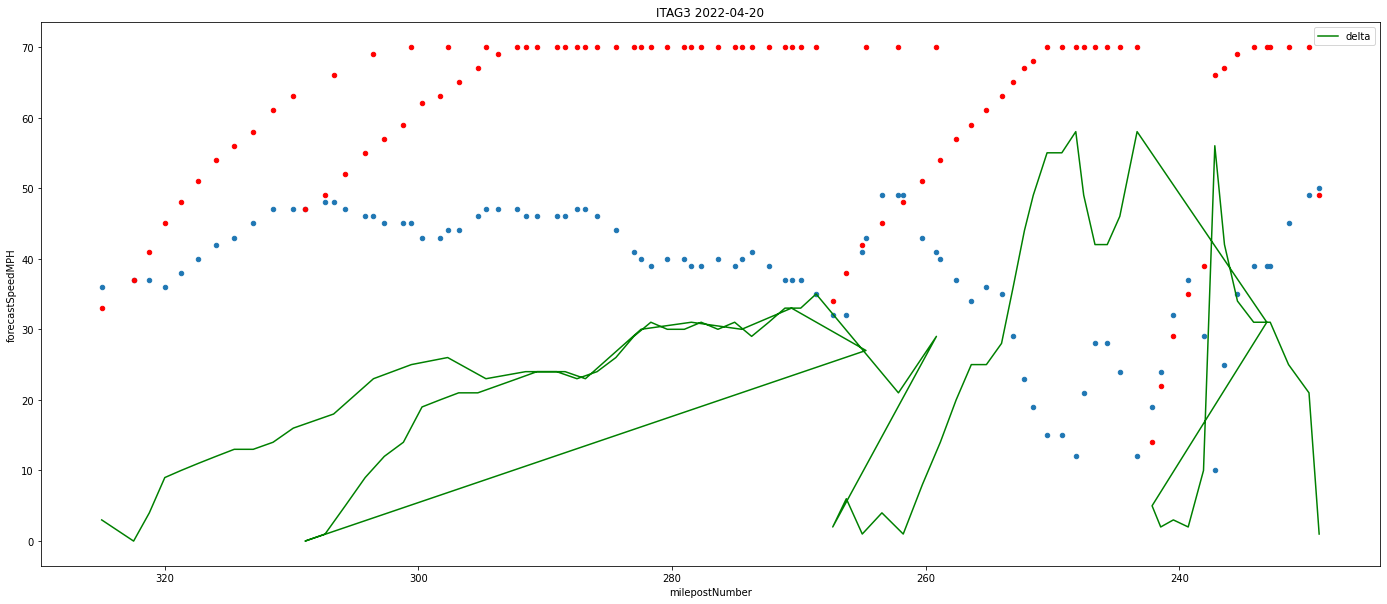

In [202]:
plotTrain(trains, trainIdsList[3])

In [ ]:
trains.head()

,index,positionTime_beop,forecastSpeedMPH,forecastTrackName,forecastMilepostNumber,positionTime_actual,speedMPH,trackName,milepostNumber,delta,milepost,millis,trainId
0,0,2022-04-21T23:31:08Z,12,WEST MAIN,766.9304,2022-04-21T23:33:08Z,10.0,WEST MAIN,766.5422,2.0,766,1650583988000,MEWLI 2022-04-21
1,1,2022-04-21T23:33:08Z,19,WEST MAIN,766.4076,2022-04-21T23:35:08Z,10.0,WEST MAIN-MAIN,766.1963,9.0,766,1650584108000,MEWLI 2022-04-21
2,2,2022-04-21T23:35:08Z,25,WEST MAIN,765.6378,2022-04-21T23:37:08Z,10.0,MAIN,765.8565,15.0,765,1650584228000,MEWLI 2022-04-21
3,3,2022-04-21T23:37:08Z,30,WEST MAIN,764.6927,2022-04-21T23:39:08Z,8.0,MAIN,765.5412,22.0,765,1650584348000,MEWLI 2022-04-21
4,4,2022-04-21T23:39:08Z,34,WEST MAIN,763.6077,2022-04-21T23:41:08Z,8.0,MAIN,765.2401,26.0,765,1650584468000,MEWLI 2022-04-21


Text(0.5, 1.0, 'Mean Error')

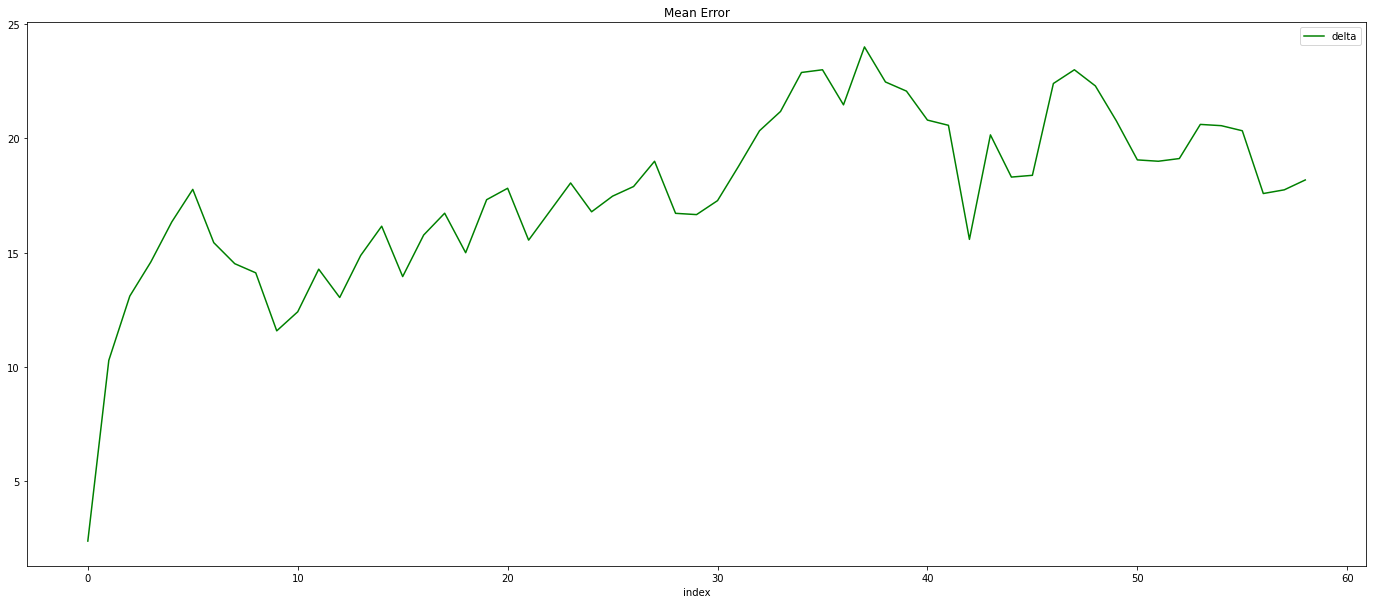

In [19]:
indexedMean = (trains[["index","delta"]]).groupby('index').mean()
indexedMean.plot( y="delta", kind="line", color="green", figsize=[24,10])
plt.title("Mean Error")

In [ ]:
meanSquaredError = math.sqrt((indexedMean['delta']**2).sum())
print("Mean Squared Error: ", meanSquaredError)

Mean Squared Error:  138.38652511796028


     milepost      delta
0         202  28.400000
1         203  32.529412
2         204  26.800000
3         205   7.333333
4         206   4.600000
..        ...        ...
164       761  31.000000
165       762  45.000000
166       763  44.500000
167       765  23.846154
168       766  21.789474

[169 rows x 2 columns]


Text(0.5, 1.0, 'Mean Error by Milepost')

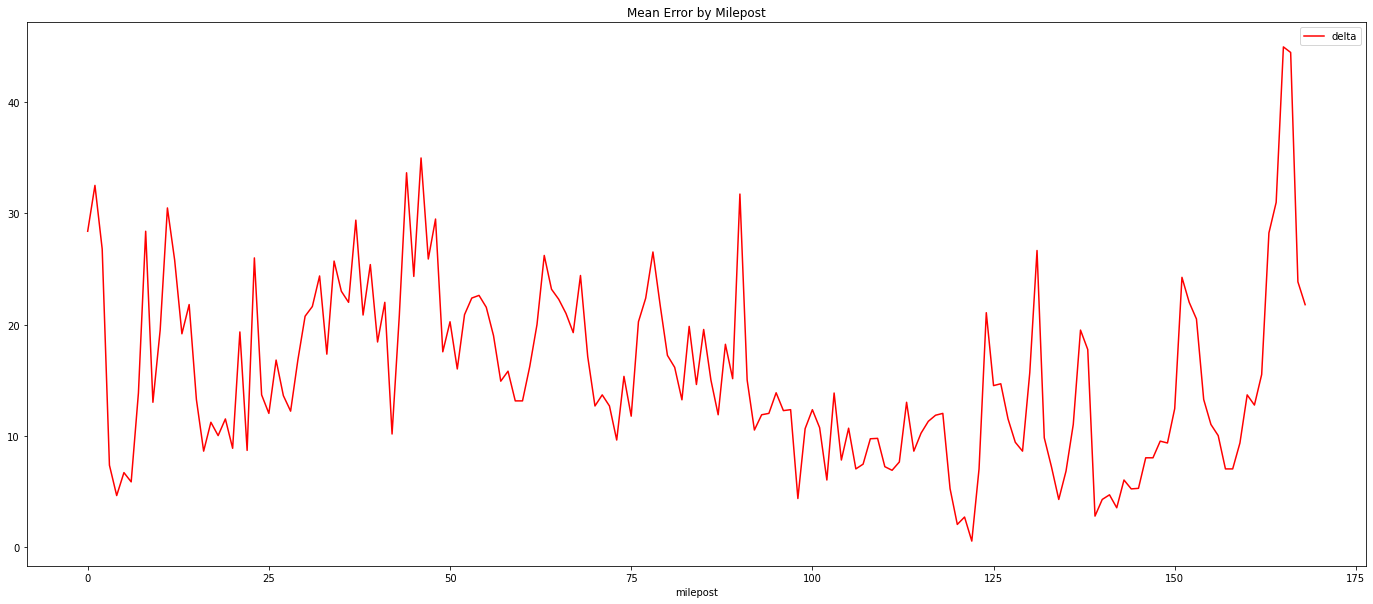

In [ ]:
indexedMeanByMilepost = (trains[["milepost","delta"]]).groupby('milepost').mean()
indexedMeanByMilepost = indexedMeanByMilepost.dropna().reset_index()
print(indexedMeanByMilepost)
indexedMeanByMilepost.plot(y="delta", use_index=True, kind="line", color="red", figsize=[24,10])
# labels= indexedMeanByMilepost['milepost'].values
plt.xlabel('milepost')
plt.title("Mean Error by Milepost")